# OperationHubをAWSに構築

----

CoursewareHubの構築、運用作業を行う環境として、OperationHubをAWSに構築します。

Amazon&nbsp;EC2インスタンスを確保します。 VPCなどのリソースを合わせて確保するため、CloudFormationを使用しています。


本Notebookでは、以下のようなVPC, Subnet, VMを構築します。

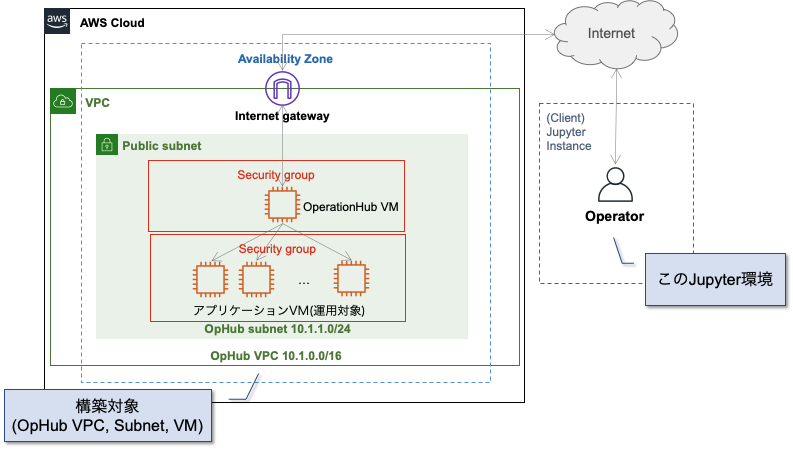

* 本Notebookを試すには、AWSのアカウントが必要です。AWSにてクレジットカード等の登録が必要な場合があります。
* t2.mediumインスタンス(2 vCPU, RAM 4GB)を使用します。使用にはAWSの料金がかかります。料金等はあらかじめ https://aws.amazon.com/jp/ec2/instance-types/t2/ で確認の上、ご自身の責任でお試しください。

# 事前条件

**事前にTerminalから、 `aws configure` を実施してください。**

`aws configure` の実施例:

```
$ aws configure
AWS Access Key ID [None]: (自身のアカウントのアクセスキー)
AWS Secret Access Key [None]: (自身のアカウントのシークレットアクセスキー)
Default region name [None]: ap-northeast-1 (使用したいリージョン)
Default output format [None]: json (jsonを指定)
```

アクセスキー管理方法は様々ありますが、AWS IAMのユーザー https://console.aws.amazon.com/iam/home?region=us-west-2#/users からNotebook用のユーザーを作成する方法があります。万が一アクセスキーが漏れた場合に備えて、権限を最小限に、いつでも無効化できるように設定する必要があります。

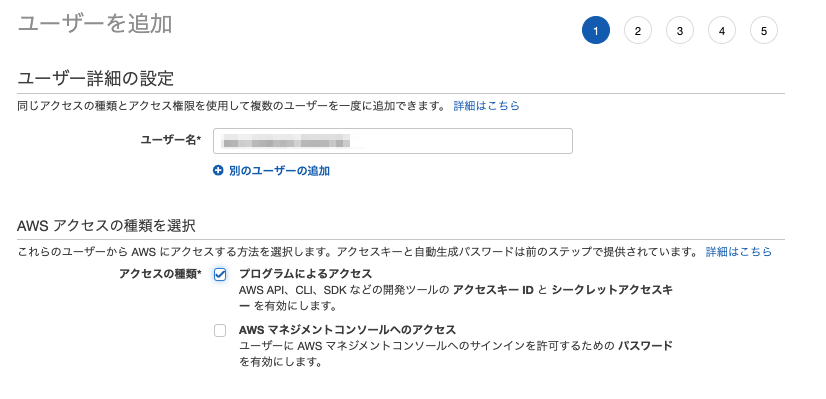

権限は `AmazonEC2FullAccess` と `AWSCloudFormationFullAccess` を想定しています。

正しくアクセス情報が指定されているかどうかを、`describe-vpcs`により確認します。**以下のコマンド実行がエラーとなる場合、`aws configure`が正しくなされていない可能性があります。**

In [ ]:
import json
import sys

vpc_result = !aws ec2 describe-vpcs
try:
    vpcs = json.loads('\n'.join(vpc_result))['Vpcs']
    print('{} VPCs exist'.format(len(vpcs)))
except:
    print(vpc_result)
    raise sys.exc_info()

本Notebookは、デモ用VPCとして、1つのVPCを追加します。

また、CloudFormationを利用してVPCやその他のリソースの準備を行います。CloudFormationのStackを1つ作成しますので、**本VMが不要になったら削除**してください。

In [ ]:
stacks_result = !aws cloudformation list-stacks
try:
    stacks = json.loads('\n'.join(stacks_result))['StackSummaries']
    print('{} Stacks exist'.format(len(stacks)))
except:
    print(stacks_result)
    raise sys.exc_info()

# リソースの定義



## CloudFormationのStack名

本Notebookが作成するリソースを管理するための CloudFormationのスタック名を設定してください。

In [ ]:
cloudformation_stack_name = 'ophubtest0001'
cloudformation_stack_name

## イメージのID

イメージは CentOS 7を前提とする。

In [ ]:
# CentOS 7
# ap-northeast-1を使用する場合
image_id = 'ami-06a46da680048c8ae'
# us-west-2 (オレゴン) を使用する場合
#image_id = 'ami-0bc06212a56393ee1'

## Keypairの準備

使用するキーペア名を設定します。

In [ ]:
resource_prefix = 'ophubtest'
resource_prefix

以下のセルは、誤ってRun Allでまとめ実行した際に先に進まないように設定しています。
これまでのセル実行が問題なければ、以下のコードセルを選択してFreezeボタンを押してFreezeして先に進めてください。

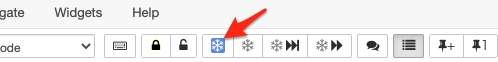

In [ ]:
# ここまでのパラメータを確認したら本セルはFreezeして先に進める。
assert False

In [ ]:
hostname = !hostname
keypair_name = '{}-{}'.format(resource_prefix, hostname[0])
keypair_name

本Notebookはインスタンスとの接続のために、 `~/.ssh/ansible_id_rsa` と言う名前の秘密鍵ファイルを生成します。
Notebook環境の `/home/jovyan` をホストディレクトリにマウントするなどして永続化していないと、この秘密鍵もコンテナの削除とともに消えますのでご注意ください。

> サンプルとしてPassphraseなしで作っています。実際の運用の際はPassphraseをつけ、ssh-agentで鍵の取り回しをしています。

In [ ]:
import os
ssh_keypath = os.path.expanduser('~/.ssh')
if not os.path.exists(os.path.join(ssh_keypath, 'ansible_id_rsa')):
    !ssh-keygen -t rsa -b 2048 -C ansible -f {ssh_keypath}/ansible_id_rsa -P ''
!cat {ssh_keypath}/ansible_id_rsa.pub

現在のキーの一覧を確認しておきます。

In [ ]:
import json
result = !aws ec2 describe-key-pairs
keypairs = json.loads('\n'.join(result))['KeyPairs']
print('{} keys'.format(len(keypairs)))

本Notebookは設定された resource_prefix 変数と hostname を使ってキーペア名を決定します。同一名称のキーペア名があれば特に何もしません。

In [ ]:
if keypair_name not in [k['KeyName'] for k in keypairs]:
    !aws ec2 import-key-pair --key-name {keypair_name} --public-key-material file://{ssh_keypath}/ansible_id_rsa.pub

# CloudFormation Stack作成

## Templateの定義

In [ ]:
import tempfile
work_dir = tempfile.mkdtemp()
work_dir

In [ ]:
%%writefile {work_dir}/template.yml
AWSTemplateFormatVersion: "2010-09-09"
Description: 'A template for OperationHub'
Parameters:
  KeyName:
    Type: String
        
  ImageId:
    Type: String

Resources:
  VPC:
    Type: "AWS::EC2::VPC"
    Properties:
      CidrBlock: 10.1.0.0/16
      EnableDnsSupport: true
      EnableDnsHostnames: true
      Tags:
      - Key: Name
        Value:  !Join ['', [!Ref "AWS::StackName", "-VPC" ]]
            
  InternetGateway:
    Type: "AWS::EC2::InternetGateway"
    DependsOn: VPC
        
  AttachGateway:
    Type: "AWS::EC2::VPCGatewayAttachment"
    Properties:
      VpcId: !Ref VPC
      InternetGatewayId: !Ref InternetGateway
        
  OpHubSubnet:
    Type: AWS::EC2::Subnet
    Properties:
      VpcId: !Ref VPC
      CidrBlock: 10.1.1.0/24
      AvailabilityZone: !Select [ 0, !GetAZs ]    # Get the first AZ in the list       
      Tags:
      - Key: Name
        Value: !Sub ${AWS::StackName}-OpHub
                
  OpHubPublicRouteTable:
    Type: AWS::EC2::RouteTable
    Properties:
      VpcId: !Ref VPC
      Tags:
      - Key: Name
        Value: OpHubPublic

  OpHubRoute1:
    Type: AWS::EC2::Route
    DependsOn: AttachGateway
    Properties:
      RouteTableId: !Ref OpHubPublicRouteTable
      DestinationCidrBlock: 0.0.0.0/0
      GatewayId: !Ref InternetGateway  
        
  OpHubPublicRouteTableAssociation:
    Type: AWS::EC2::SubnetRouteTableAssociation
    Properties:
      SubnetId: !Ref OpHubSubnet
      RouteTableId: !Ref OpHubPublicRouteTable
        
  OpHubSecurityGroup:
    Type: AWS::EC2::SecurityGroup
    Properties:
      GroupDescription: security group for OperationHub
      VpcId: !Ref VPC
      Tags:
      - Key: Name
        Value: !Sub ${AWS::StackName}-OpHubSG

  OpHubEIP:
    Type: AWS::EC2::EIP
    Properties:
      InstanceId: !Ref OpHubInstance

  OpHubInstance:
    Type: "AWS::EC2::Instance"
    Properties: 
      ImageId: !Ref ImageId
      InstanceType: t2.medium
      KeyName: !Ref KeyName
      SecurityGroupIds:
        - !Ref OpHubSecurityGroup
      SubnetId: !Ref OpHubSubnet
      Tags:
      - Key: Name
        Value: !Sub ${AWS::StackName}-OpHub
      BlockDeviceMappings:
        - DeviceName: /dev/sda1
          Ebs:
            VolumeSize: 50
            DeleteOnTermination: true

Outputs:
  OpHubInstanceId:
    Value: !Ref OpHubInstance

  OpHubIP:
    Value: !Ref OpHubEIP

  OpHubVPC:
    Value: !Ref VPC

  OpHubSubnet:
    Value: !Ref OpHubSubnet

  OpHubSecurityGroup:
    Value: !Ref OpHubSecurityGroup

## Stackの作成

Cloud FormationのStackを作成します。

In [ ]:
stack_result = !aws cloudformation create-stack --stack-name {cloudformation_stack_name} \
    --parameters ParameterKey=KeyName,ParameterValue={keypair_name} ParameterKey=ImageId,ParameterValue={image_id} \
    --template-body file://{work_dir}/template.yml
try:
    stack_id = json.loads('\n'.join(stack_result))['StackId']
    print('StackId', stack_id)
except:
    print(stack_result)
    raise sys.exc_info()

以下のセルの実行結果に表示されるURLをクリックして、作成状況を確認してください。ステータスがCREATE_COMPLETEとなれば、Stackの作成は成功です。

In [ ]:
import urllib.parse
regions = !aws configure get region
print('https://{region}.console.aws.amazon.com/cloudformation/home#/stacks/stackinfo?stackId={stack_id}'.format(region=regions[0], stack_id=urllib.parse.quote(stack_id)))

**ステータスがCREATE_COMPLETEに変化したことを確認**したら、以下のセルを実行してください。

> 以下のセルは、Stack作成中の場合はエラーとなります。

In [ ]:
describe_stack_result = !aws cloudformation describe-stacks --stack-name {stack_id}
stack_desc = json.loads(''.join(describe_stack_result))['Stacks'][0]
assert stack_desc['StackStatus'] == 'CREATE_COMPLETE', stack_desc['StackStatus']

## Security Groupの変更

CloudFormationにより、VMインスタンスが起動したようなので、Notebook環境から疎通確認をする。VMインスタンスのSecurity Groupは**デフォルトではどこからも接続を受け入れないようにしている**ので以下のURLから設定変更する。

AnsibleでのVM操作にはSSH(TCPポート22)を使用する。このJupyter Notebook環境からVMへのSSHアクセスを許可するよう適切なポートおよびアクセス元IPアドレスを指定する。**インバウンドルールを編集**ボタンを選択して、以下のようなルールを追加する。

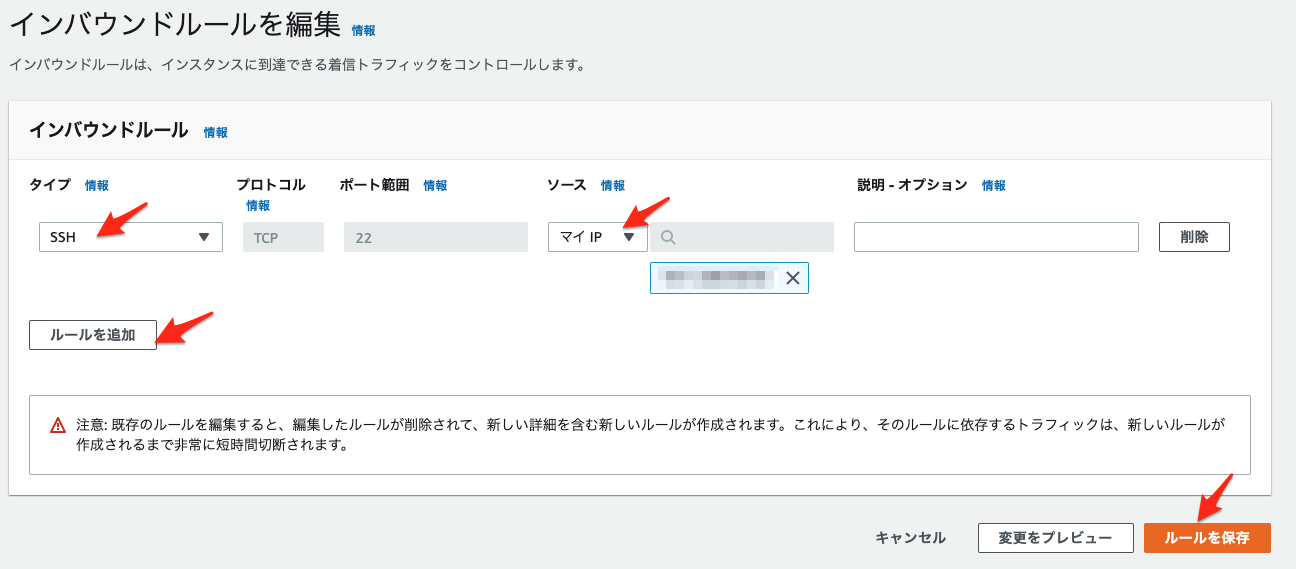

参考までに、このJupyter Notebookのアクセス元IPアドレスは以下となる。

> IPアドレスの取得に https://ifconfig.co サービスを使用します。

In [ ]:
import requests
resp = requests.get('https://ifconfig.co/json')
resp.raise_for_status()
print(resp.json()['ip'])

Security GroupのIDはStackのOutputsに記録されている。

In [ ]:
stack_desc['Outputs']

In [ ]:
security_group_id = [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'OpHubSecurityGroup'][0]
security_group_id

In [ ]:
regions = !aws configure get region
print('https://{region}.console.aws.amazon.com/ec2/v2/home?region={region}#SecurityGroup:groupId={security_group_id}'.format(region=regions[0], security_group_id=security_group_id))

In [ ]:
# セキュリティグループにSSHに関する許可が含まれていれば先に進める
sg_result = !aws ec2 describe-security-groups --group-ids {security_group_id}
sg_desc = json.loads(''.join(sg_result))['SecurityGroups'][0]

assert 'IpPermissions' in sg_desc and any([ipperm['IpProtocol'] == 'tcp' and ipperm['ToPort'] <= 22 and 22 <= ipperm['FromPort'] for ipperm in sg_desc['IpPermissions']]), sg_desc['IpPermissions']

# SSH Host Key fingerprintの取得

この後のssh接続のとき、SSH host keyを確認するため、インスタンスのSSH Host Keyをコンソール出力から取得します。

インスタンス起動直後は失敗する可能性があります。その場合は、しばらく待ってからやり直してください。

In [ ]:
instance_id = [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'OpHubInstanceId'][0]
instance_id

In [ ]:
import time

# VMのssh serverが起動して、host keyが生成されるのを待つ
time.sleep(30)

In [ ]:
console_output_result = !aws ec2 get-console-output --instance-id {instance_id}
console_output = json.loads(''.join(console_output_result))

In [ ]:
print(console_output['Output'])

In [ ]:
console_output_lines = console_output['Output'].splitlines()

ssh_hostkey_fingerprints_output = console_output_lines[
    console_output_lines.index('ec2: -----BEGIN SSH HOST KEY FINGERPRINTS-----') + 1:
    console_output_lines.index('ec2: -----END SSH HOST KEY FINGERPRINTS-----')
]
ssh_hostkey_fingerprints_output

In [ ]:
import re

ssh_hostkey_fingerprints = {}

for output in ssh_hostkey_fingerprints_output:
    m = re.match(r'^ec2:\s+(\d+)\s+([^ ]+).*\((.+)\)$', output)
    algorithm = m.group(3)
    bit = m.group(1)
    fingerprint = m.group(2)
    ssh_hostkey_fingerprints[algorithm] = (bit, fingerprint)

ssh_hostkey_fingerprints

# Ansibleユーザの設定

In [ ]:
default_username = 'centos'
default_username

In [ ]:
target_hostname = [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'OpHubIP'][0]
target_hostname

ssh host key fingerprintを確認する

In [ ]:
!ssh-keygen -R {target_hostname}

In [ ]:
import pexpect 

fingerprint_prompt = r"\(yes/no.*\)?"
password_prompt = r'password:'
prompt = r'\]\$'
    
p = pexpect.spawn("ssh -i ~/.ssh/ansible_id_rsa {}@{}".format(default_username, target_hostname))

index = p.expect([fingerprint_prompt, prompt])

if index == 0:
    msg = p.before.decode('utf-8')
    m = re.search(r'(.+) key fingerprint is', msg)
    algo = m.group(1)
    p.send('{}\n'.format(ssh_hostkey_fingerprints[algo][1]))
    
p.send('exit\n')
p.wait()

In [ ]:
import os

with open(os.path.join(work_dir, 'hosts'), 'w') as f:
    host = [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'OpHubIP'][0]
    f.write('{host} ansible_ssh_user={user} ansible_ssh_private_key_file={pkpath}\n'.format(host=host,
                                                                                          user=default_username,
                                                                                          pkpath='~/.ssh/ansible_id_rsa'))

!cat {work_dir}/hosts

In [ ]:
!ansible -m ping -i {work_dir}/hosts all

上記のセルがエラーとなる場合は、以下のように `-vvvv` オプションをつけてどんなメッセージが流れているかを確認してみましょう。

> !ansible -vvvv -m ping -i {work_dir}/hosts all
>
> Connection timed out の場合は、先のSecurity Groupがあっているかを確認すると良い...

OK。

# Inventoryへの追記

さてこれでVMが確保できました。Inventoryにhost情報を追記して、Ansibleからアクセスできるようにしましょう。


In [ ]:
if not os.path.exists('./hosts'):
    !touch ./hosts
!cp ./hosts {work_dir}/hosts-backup

Inventoryに記述する例は以下のような感じ...

In [ ]:
print('[{}]'.format(cloudformation_stack_name))
!cat {work_dir}/hosts

Inventoryを編集する。
1. [このNotebookがあるディレクトリ](/tree/) と同じ階層に `hosts` というファイルがあるので、これをクリックしてエディタを開く
2. 上記セルの出力 **2行分(スタック名とIPアドレスを含む)** をコピー＆ペーストする

`hosts`の変更差分を控えておく。

In [ ]:
# ./hostsに変更を加えるとこのセルを通過できる
! ! diff -u {work_dir}/hosts-backup ./hosts

`hosts` ファイルのテストを実施する。

Ansibleに上記で設定したグループ名を与えてpingモジュールを実行する。

In [ ]:
target_group = '-i ./hosts {}'.format(cloudformation_stack_name)
target_group

In [ ]:
!ansible -m ping {target_group}

これでVMの準備は完了です！

# About: OperationHubのインストール

# 各種設定

## インストール対象VM

対象ホストはCentOS 7 がデプロイされているものとします。

In [ ]:
!ansible -a 'cat /etc/centos-release' {target_group}

インスト－ル先ディレクトリの設定

In [ ]:
ophub_dir = '/opt/ophub'

!ansible -b -m file -a 'path={ophub_dir} state=directory' {target_group}

## ドメイン名設定

`server_name`変数に、OperationHubを動作させるホストのドメイン名を設定する。

ここではAWSで確保されたインスタンスである前提で設定する。

登録済みのドメイン名がある場合は、`server_name`にそのドメイン名を設定すること。

In [ ]:
# server_name = 'example.com'
server_name = target_hostname
assert server_name is not None, 'Unexpected result: {}'.format(''.join(ping_result))
server_name

## サーバ証明書設定

`cert_file`, `key_file` 変数に、サーバ証明書と秘密鍵のパス(Notebookサーバ上のパス)を指定する。中間証明書が必要な場合は、サーバー証明書と連結しておくこと。

空文字列を設定した場合は、自己署名証明書を作成する。


In [ ]:
cert_file = ''
key_file = ''

証明書を指定しない場合、自己署名証明書を作成

In [ ]:
import os

if not cert_file or not key_file:
    key_file = '.cert/ophub.key'
    cert_file = '.cert/ophub.cer'

    !mkdir -p {os.path.split(key_file)[0]}
    !openssl genrsa 2048 > {key_file}
    !openssl req -new -subj "/C=JP/CN={server_name}" -x509 -days 31 -key {key_file} -sha512 -out {cert_file}

存在確認

In [ ]:
!ls -l {cert_file} {key_file}

内容を確認する。

In [ ]:
!openssl x509 -in {cert_file} -noout -text

## 管理者ユーザ設定

最初に作る管理者ユーザのユーザ名及びパスワードを指定する。

PasswordはNotebookに残らないよう、getpassを使用して入力する。
パスワード入力用のフィールドが現れるので、新規作成する管理者ユーザのパスワードを入力し、ENTERを押す。

ユーザー名に使用可能な文字はA-Z, a-z, 0-9です。

In [ ]:
import getpass

admin_username = 'ohadmin'
admin_password = getpass.getpass()

In [ ]:
# ユーザ名とパスワードを確認したらFreezeして先に進める
assert False

# インストールの実施

https://github.com/NII-cloud-operation/OperationHub に従いながら...

## Step 1: Download OperationHub files

まず、対象のホストにgitをインストールする。

In [ ]:
!ansible -b -m yum -a 'name=git' {target_group}

OperationHubのリポジトリをcloneする。

リポジトリのcloneはAnsible gitモジュールを使う。

In [ ]:
!ansible -b -m git -a 'repo=https://github.com/NII-cloud-operation/OperationHub.git dest={ophub_dir}' {target_group}

cloneされたバージョンを押さえておこう... あとでうまく動作しなくなった！という時に良いヒントとなります。

In [ ]:
!ansible -a 'ls -la {ophub_dir}' {target_group}
!ansible -a 'chdir={ophub_dir} git log -1' {target_group}

##  Step 2: Install Docker Engine and docker-compose

Docker EngineとDocker Composeを対象ホストにインストールする。

In [ ]:
!ansible -b -a 'chdir={ophub_dir} ./install-docker.sh' {target_group}

## Step 3: Install the host services for OperationHub

OperationHubに必要なサービスを対象ホストにインストールする。

In [ ]:
!ansible -b -a 'chdir={ophub_dir} ./install-host-services.sh' {target_group}

## Step 4: Setting domain name

DNS名を設定します。

In [ ]:
!ansible -b -a 'chdir={ophub_dir} cat .env.sample' {target_group}

イメージ名を設定します。

Notebook環境は、この環境と同等のawscliを含むイメージを用意する。イメージはこの後にビルドする。

In [ ]:
image_name = 'niicloudoperation/aws-notebook'
image_name

設定ファイルを生成します。

詳細については、[OperationHub - Options](https://github.com/NII-cloud-operation/OperationHub#options) を参照してください。

In [ ]:
with open(os.path.join(work_dir, '.env'), 'w') as f:
    f.write('''# Server Name for nginx TLS communication (reverse proxy)
SERVER_NAME={server_name}

# JupyterHub single-user docker image
SINGLE_USER_IMAGE={image_name}

# Configuration for culling idle servers
## Enable culling
CULL_SERVER=no

## The idle timeout (in seconds) for culling server
#CULL_SERVER_IDLE_TIMEOUT=300

## The maximum age (in seconds) of servers that should be culled even if they are active
#CULL_SERVER_MAX_AGE=86400

## The interval (in seconds) for checking for idle servers to cull
#CULL_SERVER_EVERY=60

# Enable Debug Logging
# DEBUG=yes

SINGLE_USER_DEFAULT_URL=/tree
'''.format(**locals()))

!cat {work_dir}/.env

In [ ]:
!ansible -b -m copy -a 'src={work_dir}/.env dest={ophub_dir}/.env' {target_group}

## Step 5: Install TLS certificate and key

In [ ]:
!ansible -b -m file -a 'path={ophub_dir}/cert state=directory' {target_group}
!ansible -b -m copy -a 'src={cert_file} dest={ophub_dir}/cert/server.cer' {target_group}
!ansible -b -m copy -a 'src={key_file} dest={ophub_dir}/cert/server.key' {target_group}

## Step 6: Setting JupyterHub administrator

最初の管理者ユーザを設定する。ユーザ名とパスワードは 各種設定 - 管理者ユーザ設定 で実施されているものとする。

In [ ]:
from passlib.hash import sha512_crypt

# 参考: https://docs.ansible.com/ansible/faq.html#how-do-i-generate-encrypted-passwords-for-the-user-module
!ansible -b -m user -a 'name={admin_username} password={sha512_crypt.using(rounds=5000).hash(admin_password)} groups=wheel' {target_group}

## ユーザ用イメージの準備

ユーザ用イメージをあらかじめPullしておく。

In [ ]:
!ansible -b -a 'docker pull niicloudoperation/notebook' {target_group}

ユーザー用イメージのカスタマイズに使用するDockerfileを確認

In [ ]:
!cat image/Dockerfile

ユーザー用イメージをビルドする

In [ ]:
!ansible -b -m file -a 'path={ophub_dir}/singleuser-image state=directory' {target_group}
!ansible -b -m copy -a 'src=image/Dockerfile dest={ophub_dir}/singleuser-image/Dockerfile' {target_group}

In [ ]:
!ansible -b -a 'chdir={ophub_dir}/singleuser-image docker build -t {image_name} .' {target_group}

## Step 7: Starting OperationHub

関連イメージをビルドする。

In [ ]:
!ansible -b -a 'chdir={ophub_dir} docker-compose build' {target_group}

サービスを起動する。

In [ ]:
!ansible -b -a 'chdir={ophub_dir} docker-compose up -d' {target_group}

# CoursewareHub構築・運用notebookの配備

CoursewareHubの構築、運用に使用するnotebookを、管理者アカウントのディレクトリに配置する。

構築したOperationHubと同一VPCにCoursewareHubを構築するため、Cloud formationの情報を保存しておく

In [ ]:
with open(os.path.join(work_dir, 'cloudformation-stack.json'), 'w') as f:
    f.write(json.dumps(stack_desc['Outputs']))

CoursewareHub用コンテンツをコピー

In [ ]:
from glob import glob
content_files = glob('coursewarehub/*')
content_files

In [ ]:
!ansible -b -m copy -a 'src={work_dir}/cloudformation-stack.json dest=/home/{admin_username}/ owner={admin_username} group={admin_username}' {target_group}
!ansible -b -m file -a 'path=/home/{admin_username}/notebooks state=directory owner={admin_username} group={admin_username}' {target_group}
for f in content_files:
    !ansible -b -m copy -a 'src="{f}" dest=/home/{admin_username}/notebooks/ owner={admin_username} group={admin_username}' {target_group}

AWSのcredentialをコピーします。

In [ ]:
!ansible -b -m copy -a 'src=~/.aws dest=/home/{admin_username}/ owner={admin_username} group={admin_username}' {target_group}

# 動作確認

自身のPCからVMのHTTPS (TCP 443)を許可するように設定する。SSHの設定と同じ要領でOK。アクセス元IPアドレスは動作確認をするPCのものを指定すること。

In [ ]:
regions = !aws configure get region
print('https://{region}.console.aws.amazon.com/ec2/v2/home?region={region}#SecurityGroup:groupId={security_group_id}'.format(region=regions[0], security_group_id=security_group_id))

In [ ]:
# セキュリティグループにHTTPSに関する許可が含まれていれば先に進める
sg_result = !aws ec2 describe-security-groups --group-ids {security_group_id}
sg_desc = json.loads(''.join(sg_result))['SecurityGroups'][0]

assert 'IpPermissions' in sg_desc and any([ipperm['IpProtocol'] == 'tcp' and ipperm['ToPort'] <= 443 and 443 <= ipperm['FromPort'] for ipperm in sg_desc['IpPermissions']]), sg_desc['IpPermissions']

以下のURLにブラウザからアクセスする。

サーバ証明書に関する警告が出るので、適当なブラウザを使用し、例外設定して確認すること。ユーザ名とパスワードを求められたら、各種設定 の **管理者ユーザ設定** で設定したユーザ名及びパスワードでログインする。

> 下記のURLのアクセスがタイムアウトになる場合は、先のSecurity Groupで適切にHTTPSが許可されていない可能性が高い...

In [ ]:
print('https://' + server_name)
print('  Username', admin_username)
print('  Password', '入力したもの')

サービスの状態・ログは以下から確認することができます。

In [ ]:
!ansible -b -a 'chdir={ophub_dir} docker-compose ps' {target_group}

In [ ]:
!ansible -b -a 'chdir={ophub_dir} docker-compose logs jupyterhub' {target_group}

# CoursewareHubを構築するには？

CoursewareHubを構築するには、OperationHubに配備されたNotebookを以下の順に実行します。

- D01_CoursewareHub用VMをAWSに作成.ipynb
- D02_CoursewareHubインベントリの準備.ipynb
- D03_NFSの準備.ipynb
- D04_Docker Swarmの準備.ipynb
- D05_CoursewareHubの準備.ipynb

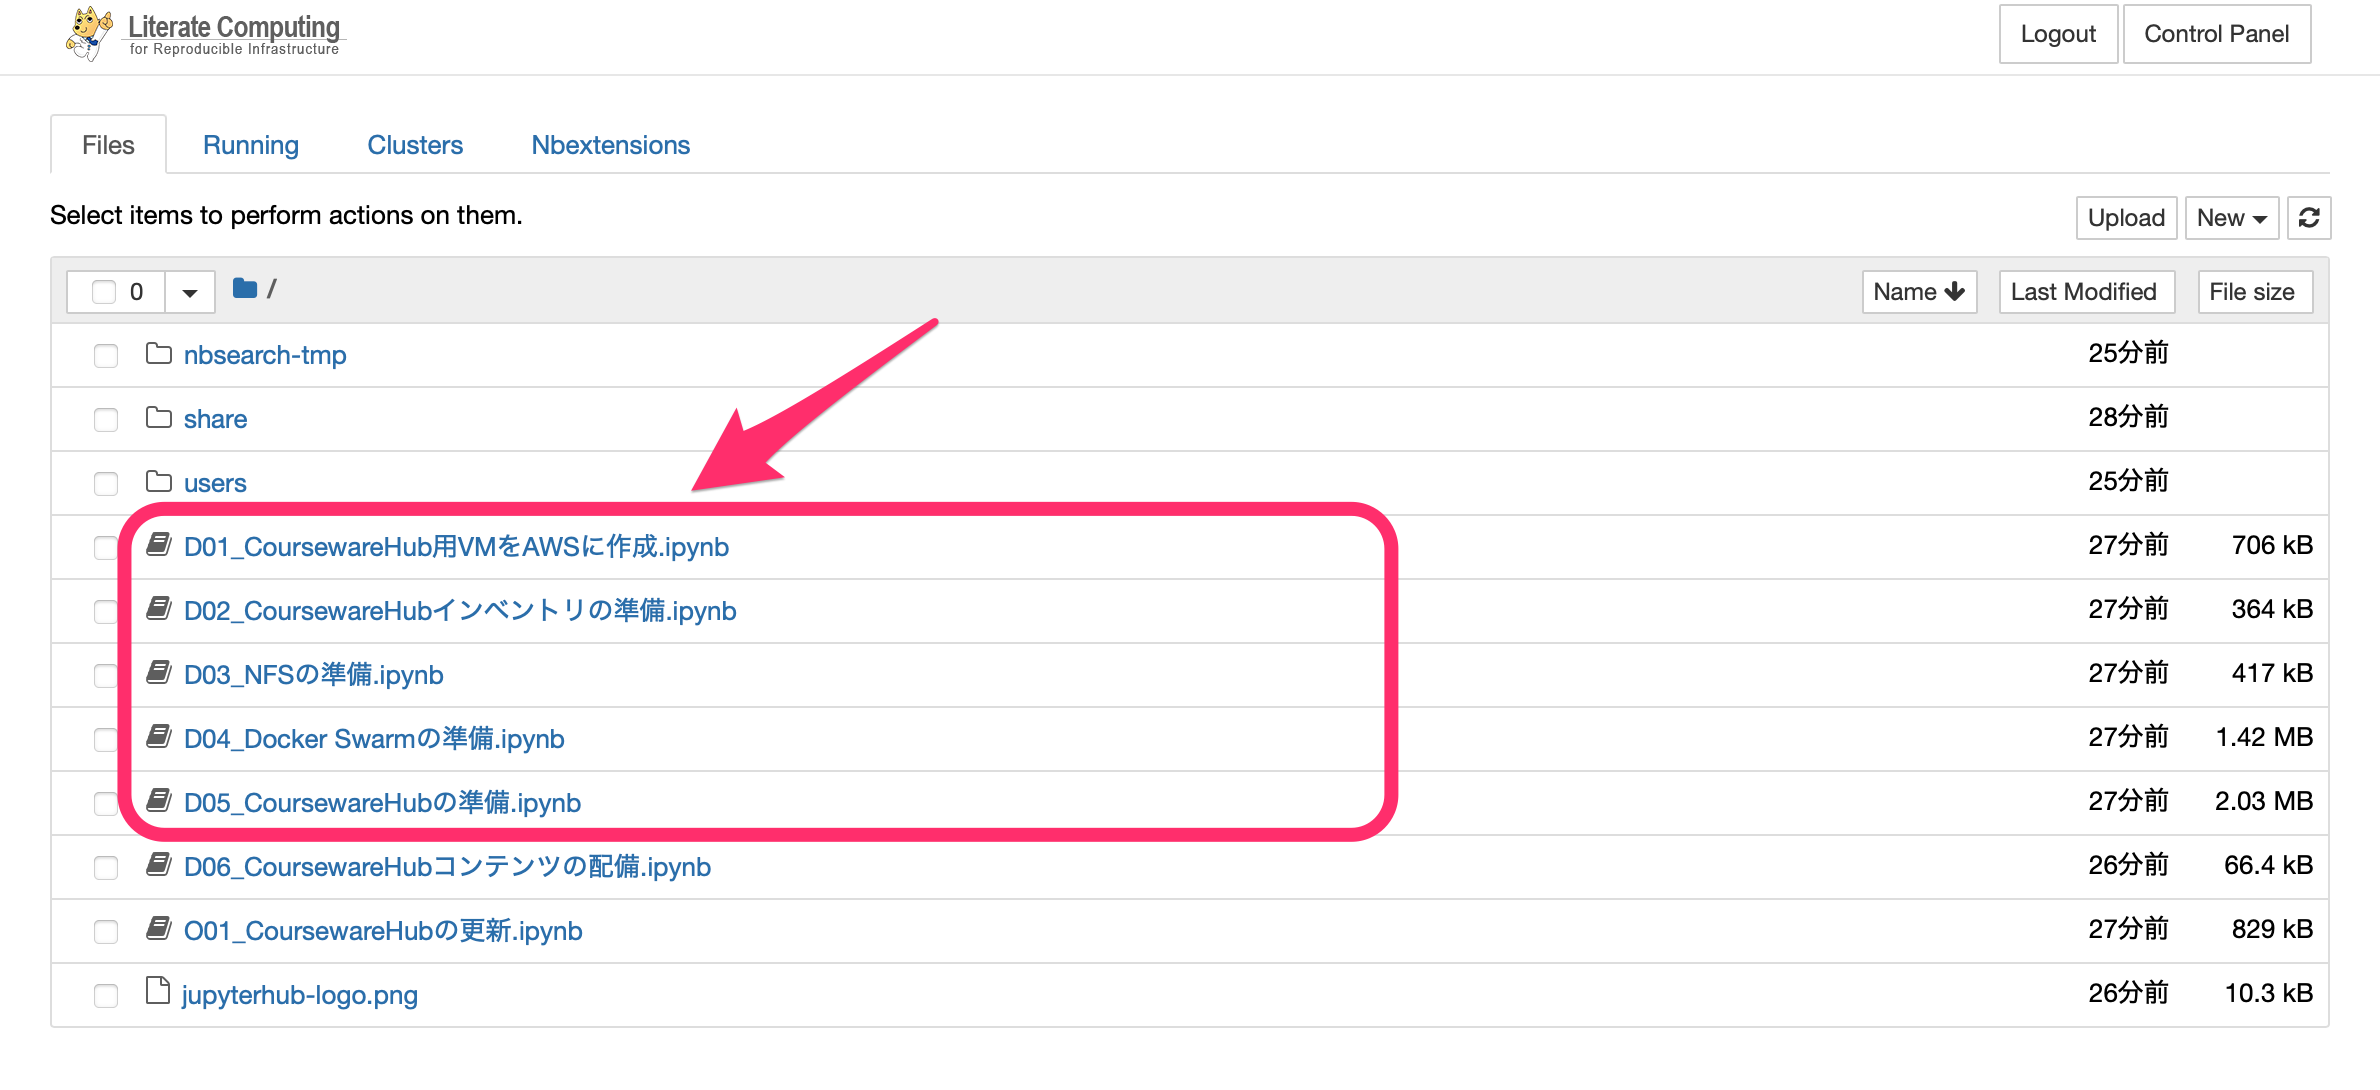

# （環境が不要になったら）不要AWSリソースの削除

AWSのリソースはCloudFormationから管理できます。

このStackを削除すると、関連するリソースを削除することができます。

> CoursewareHubなど、クラスタ内にVMやSecurity Group等を作成した場合は、その作成したVMやSecurityGroupを削除したのち、Stackを削除してください。

In [ ]:
regions = !aws configure get region
print('https://{region}.console.aws.amazon.com/cloudformation/home#/stacks/stackinfo?stackId={stack_id}'.format(region=regions[0], stack_id=urllib.parse.quote(stack_id)))